In [74]:
import pandas as pd
import numpy as np
import h5py
import scipy.io as sio
import scipy.signal 
import datetime
from skrebate import SURF, MultiSURF, SURFstar
from sklearn import svm
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import os 
import pickle
import collections
import sys
sys.path.insert(0,r'C:\Users\hfran\Desktop\FRANCIS\TWH_NURIP_Clinical_Trial\python\EUDB_Python_Framework')
import EUDB
from scipy import stats 

In [ ]:
# Helper Func Defs

def archive_data(obj, filename):
    # Save obj as pickle file. useful for saving surf classifiers 
    with open(filename, 'wb') as f:
        pickle.dump(obj, f)
        
def load_file(filename):
    # Reload pickled object as python object
    with open(filename, 'rb') as f:
        return pickle.load(f)
    
def resample_data(data, num_samps):
    # Take num_samps points from the dataset, preserving relative ordering 
    random_samp_idx = sorted(np.random.randint(data.shape[0], size=num_samps))
    return data[random_samp_idx,:]

def plot_raw_eeg(signals):
    # Plot eeg signals in matplotlib 
    p = None
    num_channels = signals.shape[1]
    
    fig, axes = plt.subplots(num_channels,1, sharex=True)
    fig.set_size_inches(8,40)
    for i in range(num_channels):
        axes[i].plot(signals[:,i])
        axes[i].set_yticks([])
        #axes[i].set_ylabel(c[i])
        
    #plt.tight_layout(w_pad=0)
    plt.autoscale(enable=True, axis='x', tight=True)
    plt.show()


def generate_feature_names(feature_list):
    """ Generating the feature names"""
    if isinstance(feature_list, int):
        n = feature_list
    else:
        n = len(feature_list)
    A, B, C = 1, 1, 1
    features = []
    for i in range(n):
        #features.append(('A{}'.format(A), 'B{}'.format(B), 'C{}'.format(C)))
        features.append([A,B,C])
        A = A + 1 if (A < 7) else 1
        B = B + 1 if (B < 6 and A == 1) else 1 if (A == 1) else B
        C = C + 1 if (B == 1 and A == 1) else C
    return features


def make_barplot(data, label):
    fig = plt.figure()
    t = list(data.items())
    t.sort(key=lambda tup: tup[1], reverse=True)
    k = len(data.items())
    x = [_[0] for _ in t][:k]
    y = [_[1] for _ in t][:k]
    y_pos = np.arange(k)
    plt.barh(y_pos, y[:k])
    plt.yticks(y_pos, x[:k])
    plt.ylabel(label + " Number")
    plt.xlabel("Aggregate Importance from Top 20")
    plt.title(label + " Importance with SURF-SVM")
    return fig 



In [ ]:
# Inputs 
data_dir = r'C:\Users\hfran\Desktop\FRANCIS\TWH113'

# Constants 
chan_names = ['LAM1','LAM2','LAM3','LAM4','LAM5','LAM6','LAM7','LAM8','LAHC1','LAHC2','LAHC3','LAHC4','LAHC5','LAHC6','LAHC7','LAHC8','LPHG1','LPHG2','LPHG3','LPHG4','LPHG5','LPHG6','LPHG7','LPHG8','LPHC1','LPHC2','LPHC3','LPHC4','LPHC5','LPHC6','LPHC7','LPHC8','RAM1','RAM2','RAM3','RAM4','RAM5','RAM6','RAM7','RAM8','RAHC1','RAHC2','RAHC3','RAHC4','RAHC5','RAHC6','RAHC7','RAHC8','RPHG1','RPHG2','RPHG3','RPHG4','RPHG5','RPHG6','RPHG7','RPHG8','RPHC1','RPHC2','RPHC3','RPHC4','RPHC5','RPHC6','RPHC7','RPHC8']

# Variables 
## pre_ictal_size indicates how many samples to take before the seizure onset_zone for test purposes 
pre_ictal_size = 10000
ictal_size = None 
n_feats = 100
window_size = 150
overlap = 0.75

In [ ]:
# 1) Load Data 
datafiles_ictal = [] 
for root, dirs, files in os.walk(data_dir):
    for f in files:
        fname_split = f.split('_')
        is_meta = fname_split[3] == 'metadata.mat'
        if is_meta:
            dataset_name = '_'.join(fname_split[:3])
            print(os.path.join(root,f))
            metadata = sio.loadmat(os.path.join(root,f))
            onset = metadata['idx_sz_start'][0][0]
            end = metadata['idx_sz_end'][0][0]
        
            
            if onset!=0 :
                filename = dataset_name + '_fvs_se.mat'
                matfile = h5py.File(os.path.join(root,filename),'r')
                fvs_data = matfile['fvs_se'][:,onset-pre_ictal_size:end].transpose()
                # for our purposes, pre-ictal will be labeled as ictal data during training
                # it'll be labelled differently for the animation 
                ictal_size = end - onset
                print(fvs_data.shape)
                
            else:
                filename = dataset_name + '_fvs_se_ss_1000.mat'
                matfile = h5py.File(os.path.join(root,filename),'r')
                fvs_data = matfile['fvs_se_ss_1000'][:,:].transpose()
                
            chan_names = matfile['chanNames']

            matfile.close()

            datafiles_ictal.append({'is_ictal' : onset!=0, 'datapath' : filename, 'data': fvs_data, 
                                       'sz_start' : onset, 'sz_end': end})


In [ ]:
# create datasets for sampling 
'''
Datasets for Training and Testing are created as follows: 
for s in seizures:
    X_train = sorted( ictals + subclinicals + intericitals )
    X_test = s 
    surf ( random sampling of X_train)
    svm.train (X_train)
    result = svm_test(X_test)
    performances.append(result)
'''

def generate_labels(data):
    # generate labels for dataset, leaving out specified datarecord 
    
    all_X = np.vstack([ x['data'] for x in data ])
    all_y = np.concatenate([ np.ones(x['data'].shape[0]) * x['is_ictal'] for x in data ])
    
    # normalize the data with zscore 
    all_X = stats.zscore(all_X)
    
    return all_X, all_y
    

def windowed_comparison(x,y, c=None):
    '''
    :param x: concatenated interictal + ictal data
    :param y: labels 
    :param c: (optional) list of surf classifiers 
    :return: list of trained surf objects
    
    windowed_comparison will sweep the provided ictal data (data with y==1) and compare it to a randomly
    generated reference window of interictal data

    Each window creates a surf object which is saved for later use. 
    SURF (and SURF_star) contain an internal list surf.feature_importances_ which 
    stores the internal weighting metric generated during the training process. 
    This weight metric is aggregated to determine which features are relevant at 
    a specific time point. 
    '''
    if not c:
        surf_train_ena = True
        c = []
    else: surf_train_ena = False
    
    interictals = x[y==0]
    ictals = x[y==1]
    
    # Create reference window 
    ref_window = resample_data(interictals, window_size) 
    ref_label = np.ones(window_size) * 0
    
    
    # Sweep over ictal transition data 
    var = 0 
    step_size = int(window_size * overlap)
    for i in range(0, ictals.shape[0]-step_size, step_size):
        print("Step {} idx: {}".format(var,i)+" {0:.0%}".format(i, i/ictals.shape[0]))
        var += 1
        if (i+window_size) > ictals.shape[0]: break 
        
        # compare window [i, i+window_size] against reference 
        exp_window = ictals[i:i+window_size,:]
        exp_label =  np.ones(window_size) * 1 
        
        # Concatenate reference with test window 
        surf_trainx = np.vstack([ref_window, exp_window])
        surf_trainy = np.concatenate([ref_label, exp_label])
        
        assert(surf_trainx.shape[0] == surf_trainy.shape[0])
        # run surf on it       
        if surf_train_ena:
            surf = SURFstar(n_features_to_select=n_feats, n_jobs=-1, verbose = True)
            surf.fit(surf_trainx, surf_trainy)
            c.append(surf)
        else:
            continue
    return c, random_samp_idx 
        
    
    

    


In [ ]:
%%time 
## 2) Generate Labels and Train SURFs
X, y = generate_labels(datafiles_ictal)
feature_names = generate_feature_names(X.shape[1])
c,ref_idx = windowed_comparison(X,y) 



Text(0.5,1,'Relative Feature Importances for 5 Classifiers')

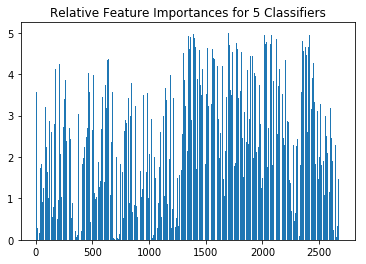

In [60]:
# 3) Plot Relative Feature Importances for debugging purposes 

plt.bar(rankings.keys(), rankings.values())
plt.title("Relative Feature Importances for {} Classifiers".format(len(cache)))

In [ ]:
def get_best_surf_features(surfs, num_features = 20):
    '''
    :param surfs: list of surf objects  
    :param num_features: pull the top <num_features> from each surf object
    :return: aggregate weights for all top num_features organized by alpha, band, channel 
    '''
    
    alpha_usage = collections.defaultdict(int)
    channel_usage = collections.defaultdict(int)
    band_usage = collections.defaultdict(int)

    for surf in surfs:
        top_idx = np.argsort(surf.feature_importances_)[-num_features:]
        for f in top_idx:
            # get the best channel by occrence
            channel = chan_names[feature_names[f][2]]
            channel_usage[channel]              += surf.feature_importances_[f]
            alpha_usage[feature_names[f][0]]    += surf.feature_importances_[f]
            band_usage[feature_names[f][1]]     += surf.feature_importances_[f]

    return alpha_usage, band_usage, channel_usage
'''
# usage example 
alpha_usage, band_usage,channel_usage = get_best_surf_features(cached_surf_list)     
f = make_barplot(alpha_usage, "Alpha")
f = make_barplot(band_usage, "Band")
f = make_barplot(channel_usage, "Channel")
'''

In [ ]:
surf_list = c

# 4) Create a movie from the series of surf classifiers and the top channel rankings over time 
# You might need to install ffmpeg for this to work 

fig, (ax1, ax2) = plt.subplots(nrows=2, gridspec_kw = {'height_ratios':[3, 1]})
# each frame of the animation corresponds to an individual window in the test set 
# the input provided is the channel weights aggregated from the top 20 features of each surf object
frames = [[get_best_surf_features([_c], num_features=20)[2], i] for i,_c in enumerate(surf_list)]
label = 'Channel'
# only the top 5 channels are actually displayed on the screen 
num_chans = 5 

# get distribution of class type from the data 
num_samps = ictal_size + pre_ictal_size
preictal_len = pre_ictal_size/num_samps
ictal_len = ictal_size/num_samps

title = 'Surf'

marking_line = ax2.axvline(0.75, ls='--', color='r')
marking_idx = 0 

def init():
    '''
    Initialize figure with labels 
    '''
    #ax1.ylabel(label + " Number")
    #ax1.xlabel("Aggregate Importance from Top 20")
    ax2.barh(0, preictal_len, color='#b5ffb9', edgecolor='white', height=0.5)
    ax2.barh(0, ictal_len, left=preictal_len, color='#f9bc86', edgecolor='white', height=0.5)  
    ax2.text(0.2, 0, 'pre-ictal', fontsize=12)
    ax2.text(0.8, 0, 'ictal', fontsize=12)

    ax2.set_xlabel('Time')
    ax2.set_yticks([])
    ax2.set_xticks([])
    return [ax1,ax2]
    
def update(frame, num_frames, num_chans):
    '''
    https://matplotlib.org/api/animation_api.html
    '''
    data = frame[0]
    idx = frame[1]
    t = list(data.items())
    t.sort(key=lambda tup: tup[1], reverse=True)
    t = t[:num_chans]
    cnames,val = zip(*t)
    y_pos = np.arange(num_chans)
    fig.suptitle('Channel Importance with SURF')

    ax1.cla()
    ax1.barh(np.arange(len(val)), val, tick_label=cnames)
    marking_line.set_xdata([idx/len(frames)])
    return [ax1,ax2]

    

ani = FuncAnimation(fig, update, frames=frames, init_func = init,
                    blit=False, interval =250 ,repeat=True, fargs=(len(frames), num_chans))


plt.show()

# uncomment to export film as an mp4
#ani.save(title+'.mp4')


